Using Tensorflow backend


In [ ]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

Importing ICBHI_final_database from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mypath="/content/drive/MyDrive/Colab Notebooks/ICBHI_final_database/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [ ]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 

Reading Demographic info file

In [ ]:
path_demo ='/content/drive/MyDrive/Colab Notebooks/icbhi_other_files/demographic_info.txt'
col_names = ['patient_id', 'age', 'sex', 'adult_bmi', 'child_weight', 'child_height']

# Adult BMI (kg/m2)
# Child Weight (kg)
# Child Height (cm)

df_demo = pd.read_csv(path_demo, sep=" ", header=None, names=col_names)

df_demo.head(10)

,patient_id,age,sex,adult_bmi,child_weight,child_height
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0
5,106,73.00,F,21.00,NaN,NaN
6,107,75.00,F,33.70,NaN,NaN
7,108,3.00,M,NaN,NaN,NaN
8,109,84.00,F,33.53,NaN,NaN
9,110,75.00,M,25.21,NaN,NaN


Reading Patient diagnosis file

In [ ]:
path_pat= \
'/content/drive/MyDrive/Colab Notebooks/icbhi_other_files/patient_diagnosis.csv'

df_diag = pd.read_csv(path_pat, header=None, names=['patient_id', 'diagnosis'])

df_diag.head(10)

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
5,106,COPD
6,107,COPD
7,108,LRTI
8,109,COPD
9,110,COPD


Reading Filename format

In [ ]:
path = \
'/content/drive/MyDrive/Colab Notebooks/icbhi_other_files/filename_format.txt.txt'

data = open(path, 'r').read()

data

'Elements contained in the filenames:\n\nPatient number (101,102,...,226)\nRecording index\nChest location (Trachea (Tc), {Anterior (A), Posterior (P), Lateral (L)}{left (l), right (r)})\nAcquisition mode (sequential/single channel (sc), simultaneous/multichannel (mc))\nRecording equipment (AKG C417L Microphone, 3M Littmann Classic II SE Stethoscope, 3M Litmmann 3200 Electronic Stethoscope, WelchAllyn Meditron Master Elite Electronic Stethoscope)'

Reading an annotated txt file of its corresponding audio file

In [ ]:
path_dis = \
'/content/drive/MyDrive/Colab Notebooks/ICBHI_final_database/101_1b1_Al_sc_Meditron.txt'

col_names = ['Beginning_of_respiratory_cycle', 'End_of_respiratory_cycle', 'Presence/absence_of_crackles', 'Presence/absence_of_wheezes']

# Respiratory cycle column values are in 'seconds'.
# Presence = 1
# Absence = 0

df_annot = pd.read_csv(path_dis, sep="\t", header=None, names=col_names)

df_annot.head(10)

,Beginning_of_respiratory_cycle,End_of_respiratory_cycle,Presence/absence_of_crackles,Presence/absence_of_wheezes
0,0.036,0.579,0,0
1,0.579,2.450,0,0
2,2.450,3.893,0,0
3,3.893,5.793,0,0
4,5.793,7.521,0,0
5,7.521,9.279,0,0
6,9.279,11.150,0,0
7,11.150,13.036,0,0
8,13.036,14.721,0,0
9,14.721,16.707,0,0


In [ ]:
path_spec = \
'/content/drive/MyDrive/Colab Notebooks/ICBHI_final_database/154_2b4_Al_mc_AKGC417L.txt'

col_names = ['Beginning_of_respiratory_cycle', 'End_of_respiratory_cycle', 'Presence/absence_of_crackles', 'Presence/absence_of_wheezes']

# Respiratory cycle column values are in 'seconds'.
# Presence = 1
# Absence = 0

df_annot = pd.read_csv(path_spec, sep="\t", header=None, names=col_names)

df_annot.head(20)

,Beginning_of_respiratory_cycle,End_of_respiratory_cycle,Presence/absence_of_crackles,Presence/absence_of_wheezes
0,1.330,3.804,0,0
1,3.804,6.396,0,0
2,6.396,8.938,1,0
3,8.938,11.580,1,0
4,11.580,14.072,1,0
5,14.072,17.049,1,0
6,17.049,19.490,1,0


We see that this recording contains 7 respiration cycles. We also see that crackles are present on 5 of the 7 cycles.

In [ ]:
# Install the pysoundfile library
! pip install pysoundfile

In [ ]:
import soundfile as sf

# Define helper functions

# We will Load .wav file. 
# These are 24 bit files. The PySoundFile library is able to read 24 bit files.

def get_wav_info(wav_file):
    data, rate = sf.read(wav_file)
    return data, rate


def graph_spectrogram(wav_file):
    data, rate = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [ ]:
path = \
'/content/drive/MyDrive/Colab Notebooks/ICBHI_final_database/154_2b4_Al_mc_AKGC417L.wav'

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


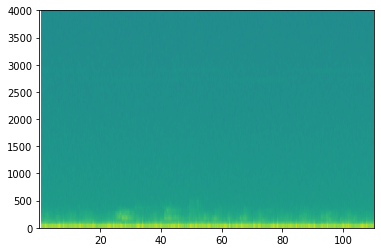

In [ ]:
x = graph_spectrogram(path)

Time is on the x axis and Frequencies are on the y axis. The intensity of the different colours shows the amount of energy i.e. how loud the sound is, at different frequencies, at different times.

**Part B: Plotting the MFCC**

In [ ]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [ ]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [ ]:
p_diag = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/icbhi_other_files/patient_diagnosis.csv",header=None) # patient diagnosis file

In [ ]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [ ]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  920  files


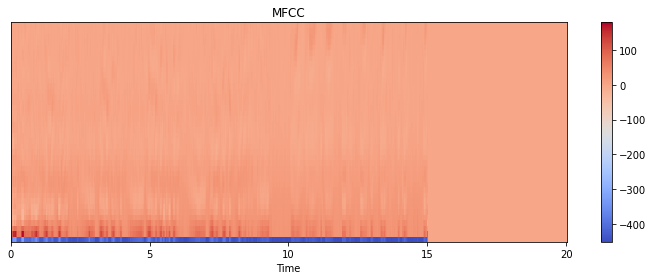

In [ ]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [ ]:
features = np.array(features) # convert to numpy array

In [ ]:
features[7].shape #find shape

(40, 862)

In [ ]:
# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [ ]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


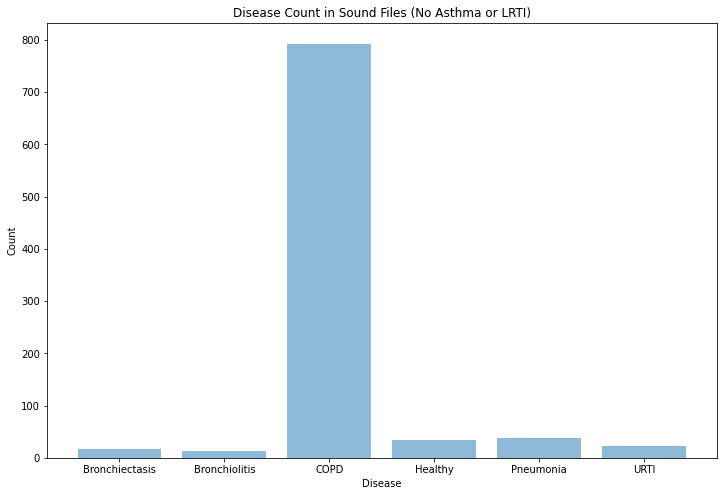

In [ ]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

**Part C: Creating CNN model**

In [ ]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 

In [ ]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42) #80% train, 20%test

We will use ReLU activation function. There will e 6 nodes in our output layer. We will use softmax as the activation function for output layer.

In [ ]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

Model construction:

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2)) #20% dropout

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 861, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 430, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 430, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 429, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 214, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 214, 32)        0